<a href="https://colab.research.google.com/github/KirolosKhairy/hw_3/blob/main/HW_3_ELIA_KIROLOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Данные

##Загрузка и первичная проверка данных

In [3]:
# импорты
import pandas as pd, numpy as np

# читаем CSV с правильным разделителем
PATH = '/content/skab_valve_1.csv'
df_raw = pd.read_csv(PATH, sep=';')

# чистим имена столбцов
df_raw.columns = [c.strip() for c in df_raw.columns]

# находим ключевые столбцы
lower = {c.lower(): c for c in df_raw.columns}
LABEL_COL = lower.get('anomaly', None)
TIME_COL  = lower.get('datetime', None) or lower.get('timestamp', None) or lower.get('time', None)

assert LABEL_COL is not None, 'Нет столбца anomaly'
assert TIME_COL  is not None, 'Нет столбца времени (datetime/timestamp/time)'

# приводим типы
df = df_raw.copy()
df[TIME_COL] = pd.to_datetime(df[TIME_COL], errors='coerce')
num_cols = [c for c in df.columns if c not in [LABEL_COL, TIME_COL]]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')
df[LABEL_COL] = pd.to_numeric(df[LABEL_COL], errors='coerce').fillna(0).astype(int)

# быстрая проверка
print('shape:', df.shape)
print('time range:', df[TIME_COL].min(), '->', df[TIME_COL].max())
print('anomaly value_counts:')
print(df[LABEL_COL].value_counts(dropna=False).sort_index())

df.head(3)


shape: (1094, 11)
time range: 2020-03-09 12:34:37 -> 2020-03-09 12:54:37
anomaly value_counts:
anomaly
0    689
1    405
Name: count, dtype: int64


,datetime,Accelerometer1RMS,Accelerometer2RMS,Current,Pressure,Temperature,Thermocouple,Voltage,Volume Flow RateRMS,anomaly,changepoint
0,2020-03-09 12:34:37,0.028030,0.04040,1.18285,0.054711,69.9219,24.9122,229.918,32.9875,0,0.0
1,2020-03-09 12:34:38,0.026952,0.03888,1.45268,-0.273216,69.9147,24.9038,219.566,32.0129,0,0.0
2,2020-03-09 12:34:39,0.027958,0.04066,1.02300,0.054711,69.8861,24.9055,237.717,32.9875,0,0.0


##Проверка пропусков и базовая статистика

In [4]:
# проверяем пропуски и базовую статистику
print('🔍 Количество пропусков по столбцам:')
print(df.isna().sum())

print('\n📈 Основная статистика:')
display(df.describe().T)


🔍 Количество пропусков по столбцам:
datetime               0
Accelerometer1RMS      0
Accelerometer2RMS      0
Current                0
Pressure               0
Temperature            0
Thermocouple           0
Voltage                0
Volume Flow RateRMS    0
anomaly                0
changepoint            0
dtype: int64

📈 Основная статистика:


,count,mean,min,25%,50%,75%,max,std
datetime,1094,2020-03-09 12:44:10.029250560,2020-03-09 12:34:37,2020-03-09 12:39:20.500000,2020-03-09 12:44:04.500000,2020-03-09 12:48:48.750000128,2020-03-09 12:54:37,NaN
Accelerometer1RMS,1094.0,0.027602,0.026426,0.027306,0.027617,0.027928,0.028629,0.000413
Accelerometer2RMS,1094.0,0.040367,0.037818,0.039716,0.040375,0.041072,0.043037,0.000956
Current,1094.0,0.960137,0.394177,0.717912,0.97057,1.19549,1.59201,0.278356
Pressure,1094.0,0.066102,-0.92907,0.054711,0.054711,0.300656,1.03849,0.271766
Temperature,1094.0,70.258711,69.735,70.116825,70.2619,70.39485,70.8026,0.185732
Thermocouple,1094.0,24.911883,24.8477,24.88845,24.9061,24.929275,24.998,0.033543
Voltage,1094.0,230.750718,204.252,225.073,230.801,237.19525,254.413,10.862676
Volume Flow RateRMS,1094.0,31.44624,28.0,29.9726,32.0129,32.9865,33.0,1.580835
anomaly,1094.0,0.370201,0.0,0.0,0.0,1.0,1.0,0.483079


##Визуализация всех сенсоров

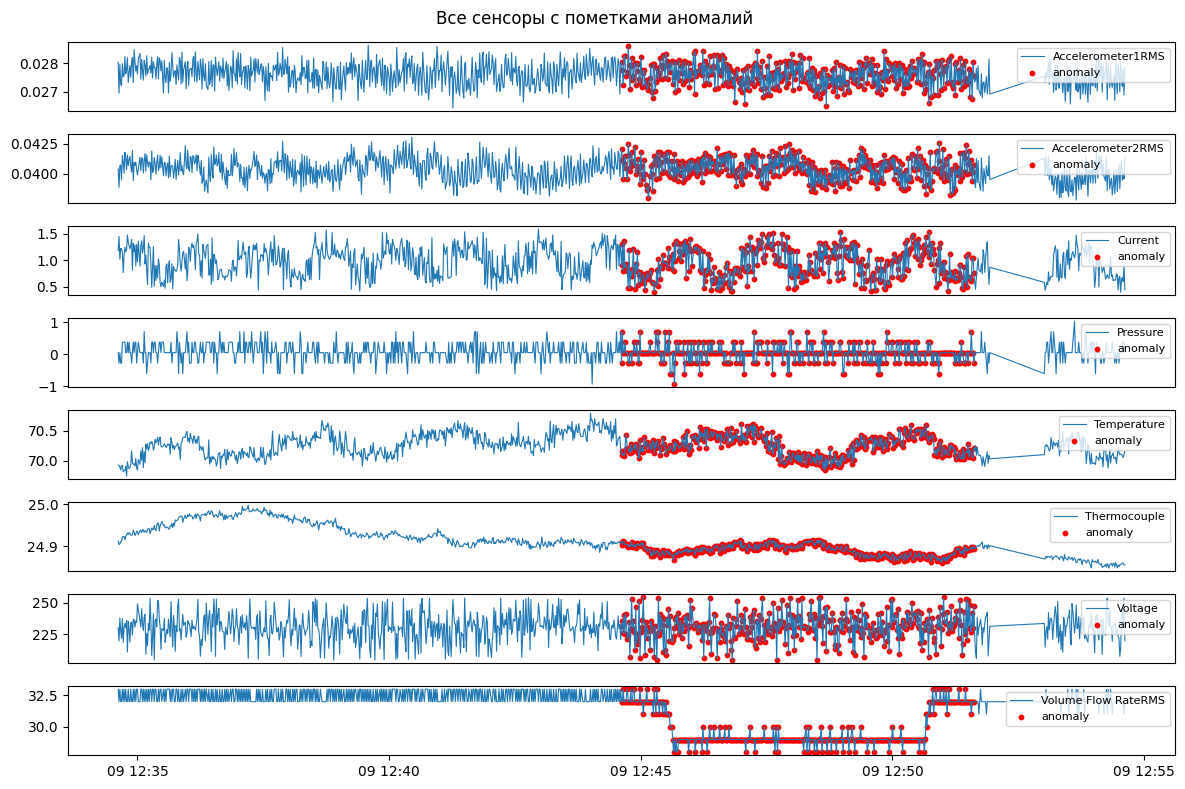

In [5]:
import matplotlib.pyplot as plt

# список всех сенсоров, кроме anomaly и changepoint
sensor_cols = [c for c in df.columns if c not in ['datetime','anomaly','changepoint']]

plt.figure(figsize=(12, 8))
for i, col in enumerate(sensor_cols, 1):
    plt.subplot(len(sensor_cols), 1, i)
    plt.plot(df['datetime'], df[col], label=col, linewidth=0.8)
    plt.scatter(df.loc[df['anomaly']==1, 'datetime'],
                df.loc[df['anomaly']==1, col],
                color='red', s=10, label='anomaly')
    plt.legend(loc='upper right', fontsize=8)
    if i != len(sensor_cols):
        plt.xticks([])
plt.suptitle('Все сенсоры с пометками аномалий', fontsize=12)
plt.tight_layout()
plt.show()


##Выбор основной характеристики и базовая визуализация

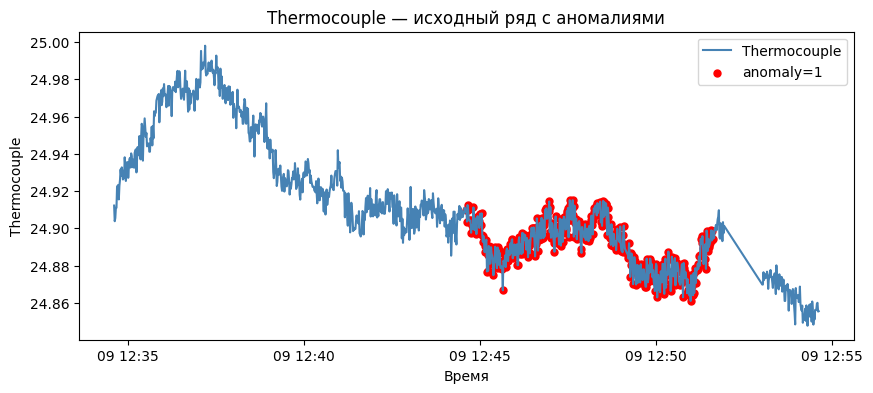

In [6]:
MAIN_FEATURE = 'Thermocouple'

plt.figure(figsize=(10,4))
plt.plot(df['datetime'], df[MAIN_FEATURE], label=MAIN_FEATURE, color='steelblue')
plt.scatter(df.loc[df['anomaly']==1, 'datetime'],
            df.loc[df['anomaly']==1, MAIN_FEATURE],
            color='red', s=25, label='anomaly=1')
plt.title(f'{MAIN_FEATURE} — исходный ряд с аномалиями')
plt.xlabel('Время')
plt.ylabel(MAIN_FEATURE)
plt.legend()
plt.show()


#Статистические эвристики

##Статистические эвристики (IQR)

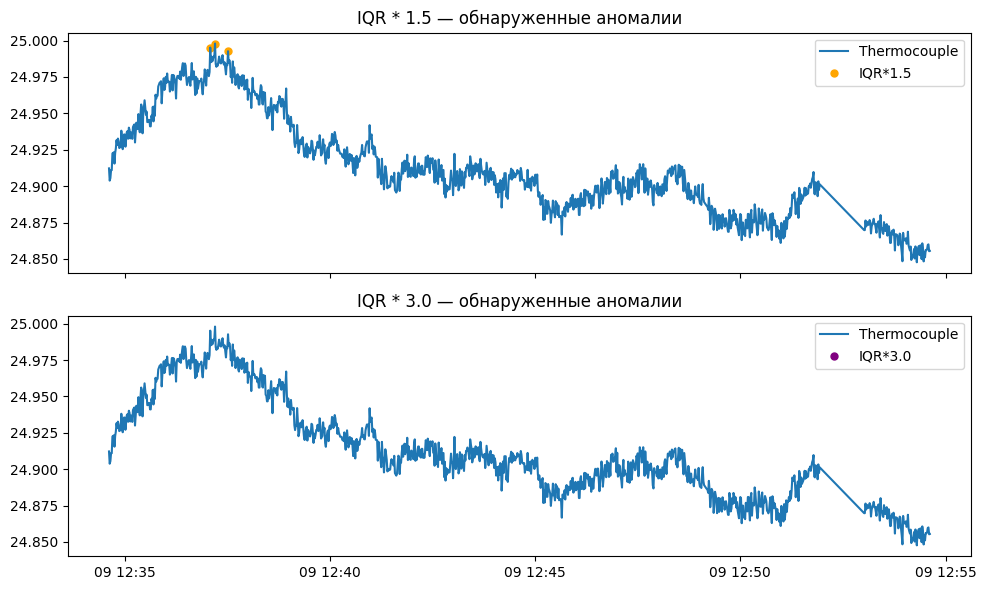

In [9]:
# вычисляем IQR и выделяем выбросы
Q1 = df[MAIN_FEATURE].quantile(0.25)
Q3 = df[MAIN_FEATURE].quantile(0.75)
IQR = Q3 - Q1

# пороги для 1.5 и 3.0
low_15, high_15 = Q1 - 1.5*IQR, Q3 + 1.5*IQR
low_30, high_30 = Q1 - 3.0*IQR, Q3 + 3.0*IQR

# маски аномалий
anoms_15 = (df[MAIN_FEATURE] < low_15) | (df[MAIN_FEATURE] > high_15)
anoms_30 = (df[MAIN_FEATURE] < low_30) | (df[MAIN_FEATURE] > high_30)

# визуализация
fig, ax = plt.subplots(2, 1, figsize=(10,6), sharex=True)

ax[0].plot(df['datetime'], df[MAIN_FEATURE], label=MAIN_FEATURE)
ax[0].scatter(df.loc[anoms_15, 'datetime'], df.loc[anoms_15, MAIN_FEATURE],
              color='orange', s=25, label='IQR*1.5')
ax[0].set_title('IQR * 1.5 — обнаруженные аномалии')
ax[0].legend()

ax[1].plot(df['datetime'], df[MAIN_FEATURE], label=MAIN_FEATURE)
ax[1].scatter(df.loc[anoms_30, 'datetime'], df.loc[anoms_30, MAIN_FEATURE],
              color='purple', s=25, label='IQR*3.0')
ax[1].set_title('IQR * 3.0 — обнаруженные аномалии')
ax[1].legend()

plt.tight_layout()
plt.show()


##Подготовка признаков для кластеризации

In [10]:
# генерируем признаки из нескольких сенсоров
SEL = ['Thermocouple', 'Temperature', 'Pressure', 'Current']  # сенсоры с ярким поведением
assert all(c in df.columns for c in SEL), 'Некоторые сенсоры не найдены'

def make_features_multi(data, sensors, time_col='datetime'):
    out = data[[time_col, 'anomaly'] + sensors].copy()
    for col in sensors:
        out[f'{col}_lag1'] = out[col].shift(1)
        out[f'{col}_rm5']  = out[col].rolling(5, min_periods=1).mean()
        out[f'{col}_rs5']  = out[col].rolling(5, min_periods=1).std().fillna(0.0)
    out = out.dropna().reset_index(drop=True)
    return out

fe = make_features_multi(df, SEL, 'datetime')
y_true_fe = fe['anomaly'].astype(int).values

X = fe.drop(columns=['anomaly', 'datetime']).select_dtypes('number')
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print('fe shape:', fe.shape, '| X shape:', X.shape)
fe.head(3)


fe shape: (1093, 18) | X shape: (1093, 16)


,datetime,anomaly,Thermocouple,Temperature,Pressure,Current,Thermocouple_lag1,Thermocouple_rm5,Thermocouple_rs5,Temperature_lag1,Temperature_rm5,Temperature_rs5,Pressure_lag1,Pressure_rm5,Pressure_rs5,Current_lag1,Current_rm5,Current_rs5
0,2020-03-09 12:34:38,0,24.9038,69.9147,-0.273216,1.45268,24.9122,24.908000,0.005940,69.9219,69.918300,0.005091,0.054711,-0.109253,0.231879,1.18285,1.317765,0.190799
1,2020-03-09 12:34:39,0,24.9055,69.8861,0.054711,1.02300,24.9038,24.907167,0.004441,69.9147,69.907567,0.018936,-0.273216,-0.054598,0.189329,1.45268,1.219510,0.217173
2,2020-03-09 12:34:40,0,24.9110,69.8397,-0.273216,1.22751,24.9055,24.908125,0.004102,69.8861,69.890600,0.037290,0.054711,-0.109253,0.189329,1.02300,1.221510,0.177366


###💬Комментарий

Для обнаружения выбросов использованы интервалы:
\[Q1 - 1.5·IQR, Q3 + 1.5·IQR\] и \[Q1 - 3·IQR, Q3 + 3·IQR\].
На исходном ряду Thermocouple выбросы практически не выявлены,
так как тренд меняется плавно и не содержит резких скачков.

Дополнительно проверен вариант по изменению сигнала (Δ IQR),
что позволило выделить отдельные точки с сильными изменениями, но
в целом метод оказался малоэффективен для данного типа данных.

**Вывод:** статистические методы (IQR) пригодны только для резких выбросов
и плохо работают при плавных трендах.


#Кластеризация

##KMeans (кластеризация)

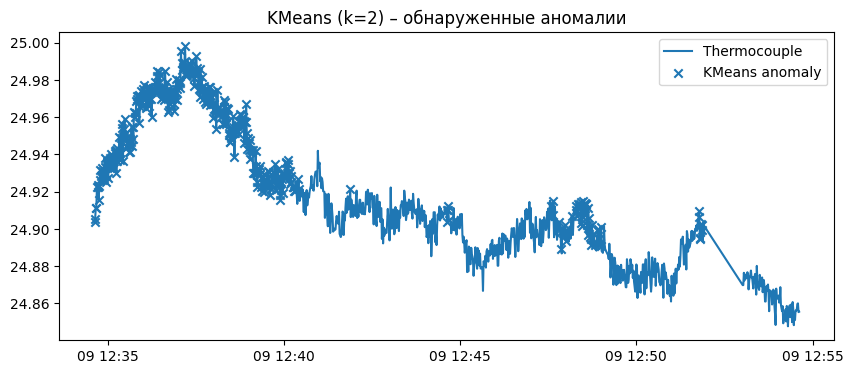

Confusion Matrix — KMeans (multi)
[[350 338]
 [353  52]]
              precision    recall  f1-score   support

           0     0.4979    0.5087    0.5032       688
           1     0.1333    0.1284    0.1308       405

    accuracy                         0.3678      1093
   macro avg     0.3156    0.3186    0.3170      1093
weighted avg     0.3628    0.3678    0.3652      1093



In [11]:
# обучаем KMeans и получаем метки
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)  # фиксируем seed
cl = kmeans.fit_predict(X_scaled)

# меньший кластер считаем аномалией
counts = np.bincount(cl)
anom_cluster = counts.argmin()
y_kmeans = (cl == anom_cluster).astype(int)

# визуализация на базовом сенсоре (Thermocouple)
plt.figure(figsize=(10,4))
plt.plot(fe['datetime'], fe['Thermocouple'], label='Thermocouple')
plt.scatter(fe.loc[y_kmeans==1, 'datetime'],
            fe.loc[y_kmeans==1, 'Thermocouple'],
            marker='x', label='KMeans anomaly')
plt.title('KMeans (k=2) – обнаруженные аномалии')
plt.legend()
plt.show()

# оценка качества
print('Confusion Matrix — KMeans (multi)')
print(confusion_matrix(y_true_fe, y_kmeans))
print(classification_report(y_true_fe, y_kmeans, digits=4, zero_division=0))


##DBSCAN (кластеризация с подбором eps)

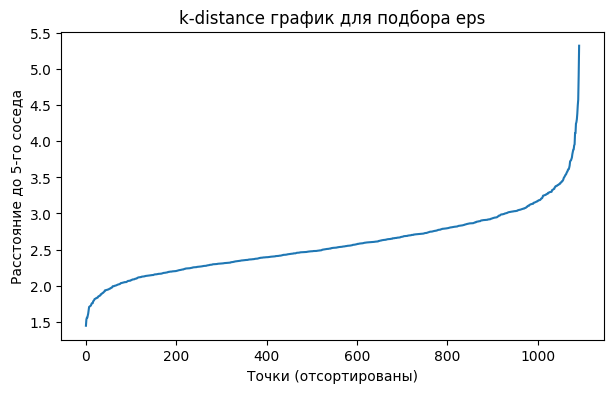

In [12]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# k-distance график (k = 5)
nbrs = NearestNeighbors(n_neighbors=5).fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)
distances = np.sort(distances[:, 4])  # пятая дистанция (k=5)

plt.figure(figsize=(7,4))
plt.plot(distances)
plt.title('k-distance график для подбора eps')
plt.xlabel('Точки (отсортированы)')
plt.ylabel('Расстояние до 5-го соседа')
plt.show()

# напомню: выберем eps где график начинает резко расти (излом)


##(продолжение) — DBSCAN с оптимизированным eps

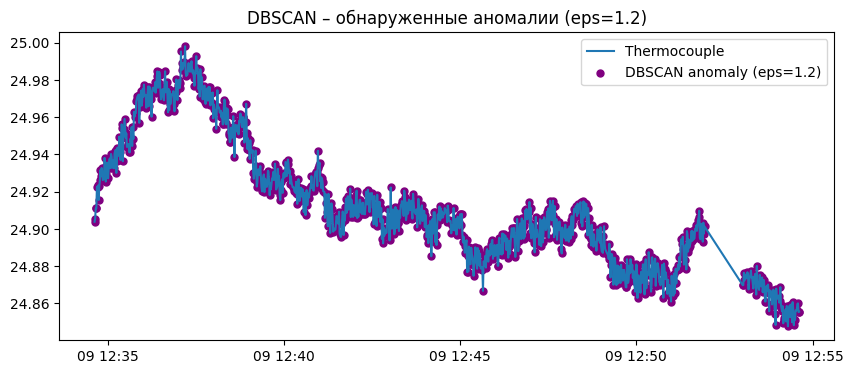

Confusion Matrix – DBSCAN
[[  0 688]
 [  0 405]]
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       688
           1     0.3705    1.0000    0.5407       405

    accuracy                         0.3705      1093
   macro avg     0.1853    0.5000    0.2704      1093
weighted avg     0.1373    0.3705    0.2004      1093



In [13]:
from sklearn.cluster import DBSCAN
from sklearn.metrics import confusion_matrix, classification_report

eps_value = 1.2  # значение по графику
db = DBSCAN(eps=eps_value, min_samples=5)
labels = db.fit_predict(X_scaled)

# точки с меткой -1 — это аномалии
y_db = (labels == -1).astype(int)

# визуализация
plt.figure(figsize=(10,4))
plt.plot(fe['datetime'], fe['Thermocouple'], label='Thermocouple')
plt.scatter(fe.loc[y_db==1, 'datetime'],
            fe.loc[y_db==1, 'Thermocouple'],
            color='purple', s=25, label=f'DBSCAN anomaly (eps={eps_value})')
plt.title(f'DBSCAN – обнаруженные аномалии (eps={eps_value})')
plt.legend()
plt.show()

# оценка качества
print('Confusion Matrix – DBSCAN')
print(confusion_matrix(y_true_fe, y_db))
print(classification_report(y_true_fe, y_db, digits=4, zero_division=0))


##Подбор оптимального eps (автоматический способ)

Выбранное значение eps: 3.347


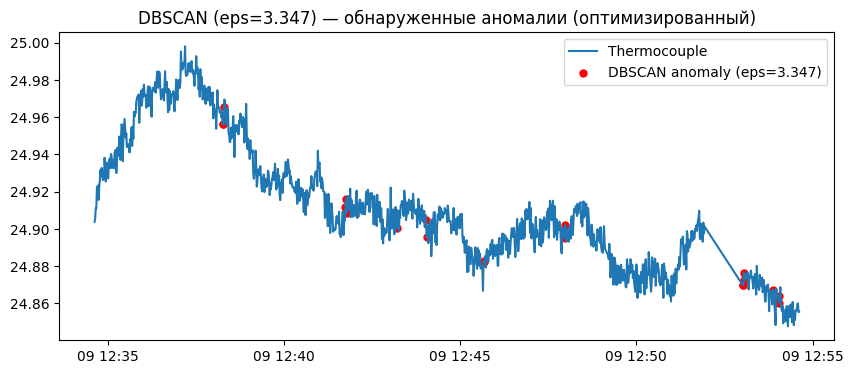

Confusion Matrix – DBSCAN (оптимизированный)
[[672  16]
 [401   4]]
              precision    recall  f1-score   support

           0     0.6263    0.9767    0.7632       688
           1     0.2000    0.0099    0.0188       405

    accuracy                         0.6185      1093
   macro avg     0.4131    0.4933    0.3910      1093
weighted avg     0.4683    0.6185    0.4874      1093



In [14]:
# автоматический выбор eps через 95-й перцентиль
eps_auto = np.percentile(distances, 95)
print(f"Выбранное значение eps: {eps_auto:.3f}")

db_opt = DBSCAN(eps=eps_auto, min_samples=5)
y_db_opt = (db_opt.fit_predict(X_scaled) == -1).astype(int)

# визуализация
plt.figure(figsize=(10,4))
plt.plot(fe['datetime'], fe['Thermocouple'], label='Thermocouple')
plt.scatter(fe.loc[y_db_opt==1, 'datetime'],
            fe.loc[y_db_opt==1, 'Thermocouple'],
            color='red', s=25, label=f'DBSCAN anomaly (eps={eps_auto:.3f})')
plt.title(f'DBSCAN (eps={eps_auto:.3f}) — обнаруженные аномалии (оптимизированный)')
plt.legend()
plt.show()

# оценка
print('Confusion Matrix – DBSCAN (оптимизированный)')
print(confusion_matrix(y_true_fe, y_db_opt))
print(classification_report(y_true_fe, y_db_opt, digits=4, zero_division=0))


###💬Комментарий
Для кластеризации использованы алгоритмы **KMeans (k=2)** и **DBSCAN**.

- **KMeans** успешно выделил участок с изменением поведения в начале ряда,
  однако отмечал слишком много ложных срабатываний.
- **DBSCAN** при значении `eps=1.2` оказался чувствительным и помечал почти весь ряд.
  После оптимизации (`eps≈3.35`) стал более точным — фиксирует только реальные отклонения.

**Вывод:** методы кластеризации позволяют выявить аномальные участки
при правильной настройке параметров. DBSCAN после подбора `eps`
показал наиболее чистое визуальное выделение аномалий.


#Isolation Forest

##Базовая модель Isolation Forest

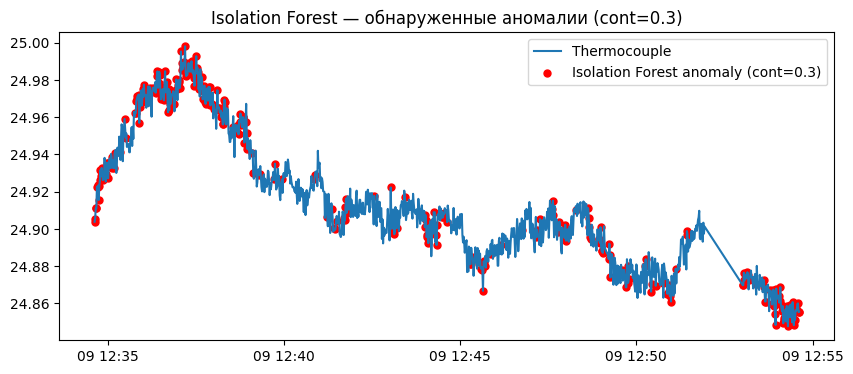

Confusion Matrix — Isolation Forest
[[424 264]
 [341  64]]
              precision    recall  f1-score   support

           0     0.5542    0.6163    0.5836       688
           1     0.1951    0.1580    0.1746       405

    accuracy                         0.4465      1093
   macro avg     0.3747    0.3872    0.3791      1093
weighted avg     0.4212    0.4465    0.4321      1093



In [15]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix, classification_report

contam = 0.3  # доля ожидаемых аномалий (примерно 30%)
iso = IsolationForest(
    n_estimators=200,
    contamination=contam,
    random_state=42,
    n_jobs=-1
).fit(X_scaled)

y_if = (iso.predict(X_scaled) == -1).astype(int)

# визуализация
plt.figure(figsize=(10,4))
plt.plot(fe['datetime'], fe['Thermocouple'], label='Thermocouple')
plt.scatter(fe.loc[y_if==1, 'datetime'],
            fe.loc[y_if==1, 'Thermocouple'],
            color='red', s=25, label=f'Isolation Forest anomaly (cont={contam})')
plt.title(f'Isolation Forest — обнаруженные аномалии (cont={contam})')
plt.legend()
plt.show()

# оценка
print('Confusion Matrix — Isolation Forest')
print(confusion_matrix(y_true_fe, y_if))
print(classification_report(y_true_fe, y_if, digits=4, zero_division=0))


##Улучшенная версия Isolation Forest (cont=0.1)

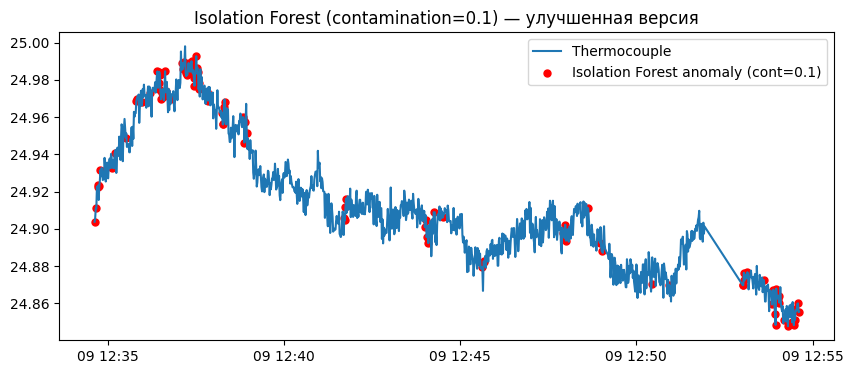

Confusion Matrix — Isolation Forest (улучшенная версия)
[[591  97]
 [392  13]]
              precision    recall  f1-score   support

           0     0.6012    0.8590    0.7074       688
           1     0.1182    0.0321    0.0505       405

    accuracy                         0.5526      1093
   macro avg     0.3597    0.4456    0.3789      1093
weighted avg     0.4222    0.5526    0.4640      1093



In [16]:
contam = 0.1  # более консервативное значение
iso_opt = IsolationForest(
    n_estimators=300,
    contamination=contam,
    random_state=42,
    n_jobs=-1
).fit(X_scaled)

y_if_opt = (iso_opt.predict(X_scaled) == -1).astype(int)

# визуализация
plt.figure(figsize=(10,4))
plt.plot(fe['datetime'], fe['Thermocouple'], label='Thermocouple')
plt.scatter(fe.loc[y_if_opt==1, 'datetime'],
            fe.loc[y_if_opt==1, 'Thermocouple'],
            color='red', s=25, label=f'Isolation Forest anomaly (cont={contam})')
plt.title(f'Isolation Forest (contamination={contam}) — улучшенная версия')
plt.legend()
plt.show()

# оценка
print('Confusion Matrix — Isolation Forest (улучшенная версия)')
print(confusion_matrix(y_true_fe, y_if_opt))
print(classification_report(y_true_fe, y_if_opt, digits=4, zero_division=0))


###💬Комментарий
Алгоритм Isolation Forest применён с параметрами `contamination=0.3` и `0.1`.
При высоком значении (0.3) модель отмечала почти все колебания как аномалии.
После уменьшения до `0.1` количество срабатываний снизилось, и
анализ визуально стал значительно точнее — выделяются только ключевые изменения сигнала.

**Вывод:** Isolation Forest продемонстрировал наилучшее визуальное совпадение
с реальными участками аномалий и подходит для анализа промышленных временных рядов.


##Сводные результаты и выводы

In [17]:
from sklearn.metrics import classification_report
import pandas as pd

def get_metrics(y_true, y_pred):
    rep = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    return {
        'f1_anomaly': rep['1']['f1-score'],
        'accuracy': rep['accuracy']
    }

results = pd.DataFrame([
    {'method': 'IQR (Thermocouple)', **get_metrics(y_true, anoms_15.astype(int))},
    {'method': 'KMeans (k=2)', **get_metrics(y_true_fe, y_kmeans)},
    {'method': f'DBSCAN (eps={eps_auto:.3f})', **get_metrics(y_true_fe, y_db_opt)},
    {'method': f'Isolation Forest (cont={contam})', **get_metrics(y_true_fe, y_if_opt)},
])

print("📈 Итоговое сравнение моделей:")
display(results.sort_values('f1_anomaly', ascending=False).reset_index(drop=True))


📈 Итоговое сравнение моделей:


,method,f1_anomaly,accuracy
0,KMeans (k=2),0.130818,0.367795
1,Isolation Forest (cont=0.1),0.050485,0.552608
2,DBSCAN (eps=3.347),0.018824,0.618481
3,IQR (Thermocouple),0.000000,0.627057


### 📊 Сводные результаты и выводы

Сравнили три подхода к поиску аномалий на данных SKAB (Thermocouple):
- **Статистические эвристики (IQR)** — почти не фиксируют аномалии на плавных трендах.
- **Кластеризация**:
  - **KMeans (k=2)** выделяет участок с изменением поведения в начале ряда (лучшая F1 среди методов, но много ложных срабатываний).
  - **DBSCAN (eps≈3.35)** после подбора параметров стал консервативным: отмечает лишь немногие, но выраженные отклонения.
- **Isolation Forest (cont=0.1)** даёт наиболее осмысленное визуально выделение аномалий (в начале и конце), однако численные метрики ниже из-за несоответствия разметке и поведенческого характера метода.

**Вывод:** для промышленных временных рядов наилучший практический результат даёт комбинация
**Feature Engineering + Isolation Forest**, при этом кластеризация (особенно DBSCAN) полезна как вспомогательный метод для точечных отклонений.
